# Analysis

In [41]:
import json

with open('../1-coding/dataset.json', 'r') as o:
    original_dataset = json.load(o)
    original_dataset = [item for item in original_dataset if item['type'] == 'commit']

with open('../1-coding/diffs.json', 'r') as f:
    diffs = json.load(f)

with open('../1-coding/codes.json', 'r') as cf:
    codes = json.load(cf)

## Dataset

In [42]:
def repo_name(item: dict[str]) -> str:
    _, _, _, owner, repo, *_ = item['url'].split('/')
    return f'{owner}/{repo}'

TOTAL = len(original_dataset)
TOTAL_REPOS = len(set(repo_name(item) for item in original_dataset))

retrieved = len(diffs)
retrieved_repos = len(set(repo_name(d) for d in diffs))
print('retrieved commits:', f'{retrieved}/{TOTAL}', f'({retrieved/TOTAL*100:.2f}%)')
print('retrieved repos:', f'{retrieved_repos}/{TOTAL_REPOS}', f'({retrieved_repos/TOTAL_REPOS*100:.2f}%)')

with_saving = len([d for d in diffs if 'saving' in d['existing_codes']])
print('\noriginally coded with `saving`:', f'{with_saving}/{retrieved}', f'({with_saving/retrieved*100:.2f}%)')

n_processed = sum(len(d['codes']) != 0 for d in diffs)
n_processed_with_saving = sum(len(d['codes']) != 0 and 'saving' in d['existing_codes'] for d in diffs)
print('\nprocessed commits:', f'{n_processed}/{retrieved}', f'({n_processed/retrieved*100:.2f}%)')
print('processed commits originally coded with `saving`:', f'{n_processed_with_saving}/{with_saving}', f'({n_processed_with_saving/with_saving*100:.2f}%)')

no_cost_change = sum('no_cost_change' in d['codes'] for d in diffs)
print('\ncommits coded with `no_cost_change`:', f'{no_cost_change}/{n_processed}', f'({no_cost_change/retrieved*100:.2f}%)')

avg_files = sum(len(d['files']) for d in diffs) / len(diffs)
print('\nfiles affected (avg):', f'{avg_files:.2f}')

retrieved commits: 567/606 (93.56%)
retrieved repos: 414/445 (93.03%)

originally coded with `saving`: 380/567 (67.02%)

processed commits: 567/567 (100.00%)
processed commits originally coded with `saving`: 380/380 (100.00%)

commits coded with `no_cost_change`: 199/567 (35.10%)

files affected (avg): 4.37


## Codes

In [43]:
import polars as pl

codes_counts = [
    c | { 'count': sum((c['name'] in d['codes']) for d in diffs) }
    for c in codes
]

codes_df = pl.DataFrame(codes_counts) \
            .with_columns(percentage=pl.col('count') / n_processed * 100) \
            .sort(by=pl.col('count'), descending=True)

print(codes_df)

codes_df.drop("percentage").write_csv("codes.csv")

shape: (161, 4)
┌─────────────────────────────────┬─────────────────────────────────┬───────┬────────────┐
│ name                            ┆ description                     ┆ count ┆ percentage │
│ ---                             ┆ ---                             ┆ ---   ┆ ---        │
│ str                             ┆ str                             ┆ i64   ┆ f64        │
╞═════════════════════════════════╪═════════════════════════════════╪═══════╪════════════╡
│ aws                             ┆ Specific to Amazon Web Service… ┆ 413   ┆ 72.839506  │
│ no_cost_change                  ┆ The commit contents do not ref… ┆ 199   ┆ 35.097002  │
│ cheaper_instance                ┆ Use a cheaper compute instance  ┆ 84    ┆ 14.814815  │
│ gcp                             ┆ Specific to Google Cloud Platf… ┆ 71    ┆ 12.522046  │
│ azure                           ┆ Specific to Azure               ┆ 58    ┆ 10.229277  │
│ …                               ┆ …                               ┆ …   

### Cloud-specific Codes

In [45]:
clouds = {'digitalocean', 'aws', 'gcp', 'azure', 'alicloud', 'scaleway', 'hcloud', 'ibm', 'oracle', 'ovh', 'fastly'}

cloud_codes = codes_df.filter(pl.col('name').is_in(clouds)).drop('description')

with pl.Config(tbl_rows=100):
    print(cloud_codes)

cloud_codes.write_csv('clouds.csv', include_header=True)

# for name, count, pct in cloud_codes.iter_rows():
#     print(f'{name} & {count} & {pct:.1f}\\%', '\\\\\n\\midrule')

non_cloud_codes = codes_df.filter(pl.col('name').is_in(clouds).not_()).drop('description')

print(non_cloud_codes)

# There is a difference between number of commits and number of cloud occurrences
# explained by cloud migrations, multi-cloud deployments and commits that do not reference cloud providers
print(cloud_codes.select('count').sum())
for d in diffs:
    n_clouds = len(set(d['codes']) & clouds)
    if n_clouds != 1:
        print(d['url'], d['codes'])

shape: (11, 3)
┌──────────────┬───────┬────────────┐
│ name         ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ str          ┆ i64   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ aws          ┆ 413   ┆ 72.839506  │
│ gcp          ┆ 71    ┆ 12.522046  │
│ azure        ┆ 58    ┆ 10.229277  │
│ digitalocean ┆ 13    ┆ 2.292769   │
│ scaleway     ┆ 4     ┆ 0.705467   │
│ hcloud       ┆ 2     ┆ 0.352734   │
│ ibm          ┆ 2     ┆ 0.352734   │
│ oracle       ┆ 2     ┆ 0.352734   │
│ alicloud     ┆ 1     ┆ 0.176367   │
│ ovh          ┆ 1     ┆ 0.176367   │
│ fastly       ┆ 1     ┆ 0.176367   │
└──────────────┴───────┴────────────┘
shape: (150, 3)
┌─────────────────────────────────┬───────┬────────────┐
│ name                            ┆ count ┆ percentage │
│ ---                             ┆ ---   ┆ ---        │
│ str                             ┆ i64   ┆ f64        │
╞═════════════════════════════════╪═══════╪════════════╡
│ no_cost_change                  ┆ 19

#### Plot top N non-cloud codes and cloud codes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'cheaper_instance'),
  Text(1, 0, 'new_gen'),
  Text(2, 0, 'remove_nat_gateway'),
  Text(3, 0, 'dynamo_on_demand'),
  Text(4, 0, 'cheaper_volume'),
  Text(5, 0, 'add_billing_alarm'),
  Text(6, 0, 'smaller_disk'),
  Text(7, 0, 'cheaper_disk_type'),
  Text(8, 0, 'add_budget'),
  Text(9, 0, 'remove_nat')])

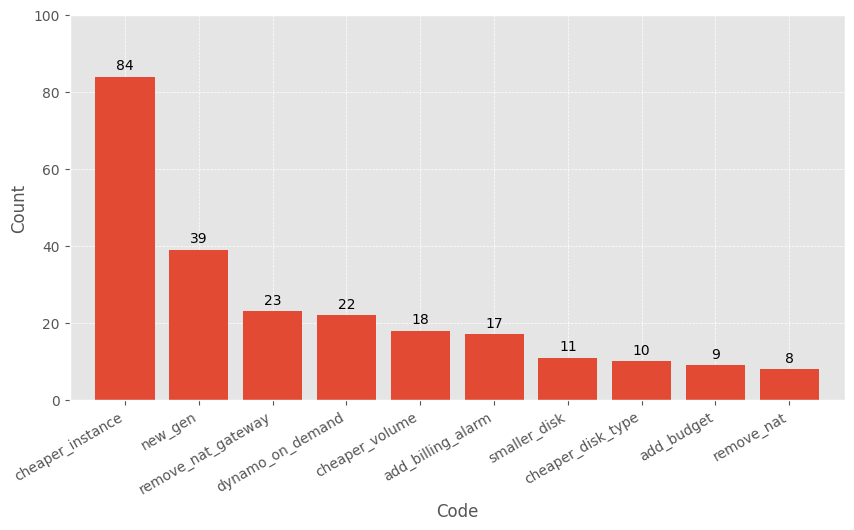

In [87]:
import matplotlib.pyplot as plt

TOP_N = 10
codes_hist_names = non_cloud_codes.get_column('name').to_list()[1:TOP_N+1]
codes_hist_counts = non_cloud_codes.get_column('count').to_list()[1:TOP_N+1]

plt.style.use('ggplot')

plt.figure(figsize=(10, 5))
bars = plt.bar(codes_hist_names, codes_hist_counts)

plt.bar_label(bars, padding=3)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('Code')
plt.ylabel('Count')
plt.ylim(0, 100)
plt.xlim(-0.75, TOP_N-0.25)
plt.xticks(rotation=30, ha='right')

(0.0, 450.0)

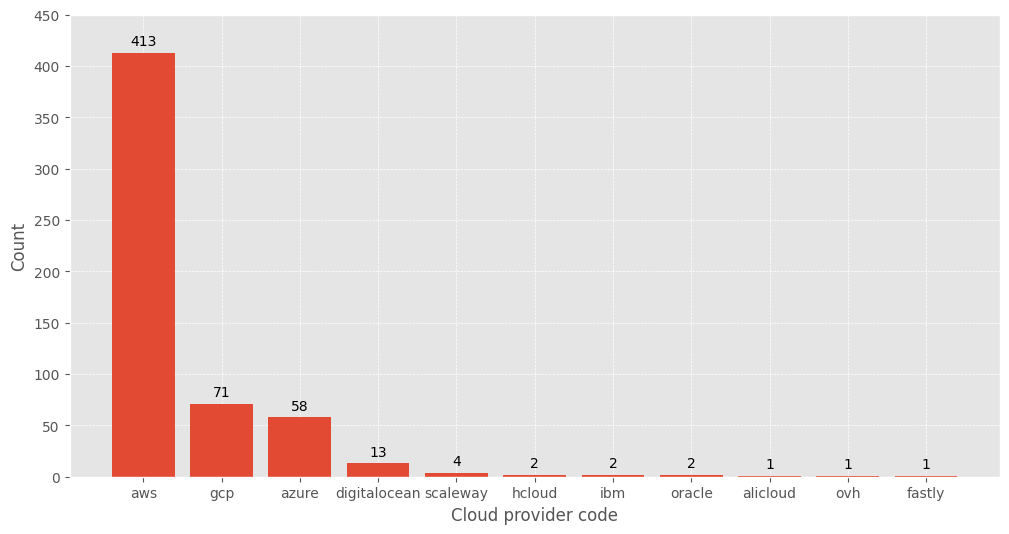

In [46]:
cloud_names = cloud_codes.get_column('name').to_list()
cloud_counts = cloud_codes.get_column('count').to_list()

plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
bars = plt.bar(cloud_names, cloud_counts)

plt.bar_label(bars, padding=3)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('Cloud provider code')
plt.ylabel('Count')
plt.ylim(0, 450)

### Uniqueness

Determine how many unique owners the code occurs for, to see if there is actually a pattern across developers/organizations.

In [47]:
def repo_owner(diff: dict[str, str]) -> str:
    _, _, _, owner, *_ = diff['url'].split('/')
    return owner

n_owners = len(set(repo_owner(d) for d in diffs))
print('number of unique owners:', n_owners)

owners = [
    {
        'name': c['name'],
        'owners': list(set(repo_owner(d) for d in diffs if c['name'] in d['codes']))
    }
    for c in codes
]
owners_df = pl.DataFrame(owners) \
                .with_columns(n_owners=pl.col('owners').list.len()) \
                .sort(by=pl.col('n_owners'), descending=True)

filtered = owners_df.filter(pl.col('name').is_in(clouds).not_()).filter(pl.col('n_owners') >= 2)

print(filtered)

#filtered.drop('owners').write_csv('unique_owners.csv')

number of unique owners: 360
shape: (50, 3)
┌─────────────────────────────────┬─────────────────────────────────┬──────────┐
│ name                            ┆ owners                          ┆ n_owners │
│ ---                             ┆ ---                             ┆ ---      │
│ str                             ┆ list[str]                       ┆ u32      │
╞═════════════════════════════════╪═════════════════════════════════╪══════════╡
│ no_cost_change                  ┆ ["Midas-Protocol", "UriKatsirP… ┆ 130      │
│ cheaper_instance                ┆ ["ayltai", "TimonB", … "circle… ┆ 64       │
│ new_gen                         ┆ ["travis-ci", "cisagov", … "ci… ┆ 27       │
│ dynamo_on_demand                ┆ ["poldi2015", "kperson", … "je… ┆ 21       │
│ remove_nat_gateway              ┆ ["Midas-Protocol", "masterpoin… ┆ 18       │
│ …                               ┆ …                               ┆ …        │
│ reduce_eip                      ┆ ["simplygenius", "stSoftwareA

### Undefined codes

List codes which are attached to commits but not defined in `codes.json`.

In [48]:
listed_codes = set(c['name'] for c in codes)
for d in diffs:
    for c in d['codes']:
        if c not in listed_codes:
            print(f'{c} is not listed')